# Семинар по OpenCV | Домашнее задание 3

**Задачи:**

1. Повернуть изображение относительно его центра (а не начала координат).

2. Используя аффинные преобразования, "выправить" изображения (привести в исходный вид), которые были подвернуты различным деформациям.


**Данные:** изображения `../data/messi5.jpg`, `../data/apple.jpg`, `../data/phone.png`, `../data/skull.png`, `../data/text.png`

---

Импорт библиотек:

In [1]:
import numpy as np
import cv2 as cv

import os
from typing import List, Tuple

from math import sin, cos, pi, radians
from scipy import ndimage

import matplotlib.pyplot as plt

Задание пути до папки с изображениями:

In [2]:
PATH = '../data/'

Задание функции, возвращающей получаемое по переданному пути изображение в формате RGB:

In [3]:
def get_image_rgb(path: str, img_name: str) -> np.ndarray:
    img = os.path.join(path, img_name)

    img = cv.imread(img, )
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    return img

---

>**Задание 1**
>
>На занятии мы разбирали, как осуществить поворот изображения с помощью матрицы поворота. Однако мы с вами заметили, что поворот происходит относительно нуля координат, что может приводить не совсем к тому результату, который мы ожидаем получить. Задача состоит в том, чтобы повернуть изображение относительно его центра (а не начала координат). 
>
>*Подсказка: вспомните идею решения, которую мы обсуждали на занятии - необходимо сделать перенос центра изображения в начало СК, затем осуществить поворот, а затем перенести обратно в центр.*
>
>Дополнительный вопрос: можем ли мы эти три преобразования соединить в одно? Другими словами, построить композицию преобразований в виде единой матрицы? Как это сделать? Для проведения экспериментов используйте изображение `messi5.jpg`

Чтение изображения:

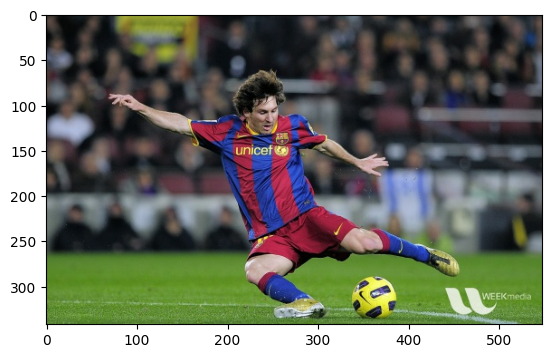

In [4]:
image_messi = get_image_rgb(PATH, 'messi5.jpg')

plt.imshow(image_messi)

<br>

**Поворот изображения относительно нуля координат**

Задание функции, выводящей изображение до и после преобразования:

In [5]:
def plot_image_before_after(img_before: np.ndarray, 
                            img_after: np.ndarray,
                            titles: List[str] = ['Init', 'Transformed'],
                            share_x: bool = True,
                            share_y: bool = True) -> None:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=share_x, sharey=share_y, figsize=(12, 6))
    title_before, title_after = titles
    
    ax1.imshow(img_before)
    ax1.set_title(title_before)
    
    if share_x is False:
        ax1.set_xticks([])
        ax1.set_yticks([])
    
    ax2.imshow(img_after)
    ax2.set_title(title_after)
    
    if share_x is False:
        ax2.set_xticks([])
        ax2.set_yticks([])
    
    if share_x:
        plt.xticks([])
        plt.yticks([])

    plt.show()

Задание функции, поворачивающей изображение относительно нуля координат:

In [6]:
def rotate_origin(img: np.ndarray, affine: np.ndarray) -> np.ndarray:
    height, width = img.shape[:2]
    result = cv.warpAffine(img, affine, (width, height))
    
    return result

Задание афинного преобразования:

In [7]:
angle = 30 * pi / 180

M = np.float32([
    [cos(angle), -sin(angle), 0],
    [sin(angle), cos(angle), 0]]
)

Поворот изображения:

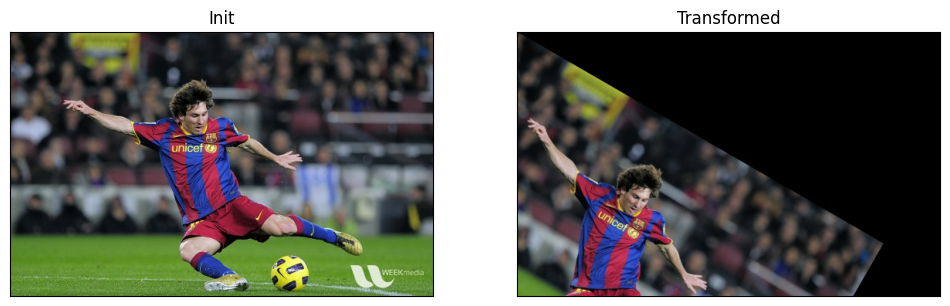

In [8]:
plot_image_before_after(image_messi, rotate_origin(image_messi, M))

<br>

**Поворот изображения относительно его центра**

Выведение на экран центра изображения:

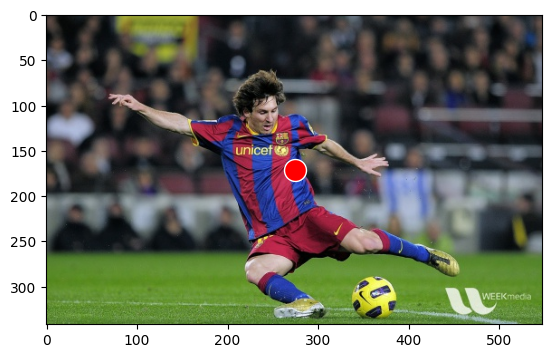

In [9]:
image_center = tuple(np.array(image_messi.shape[1::-1]) / 2)

plt.imshow(image_messi)
plt.scatter(*image_center, c='red', marker='.', s=1000, edgecolors='white')

<br>

**Способ 1** - Поворот изображения относительно его центра с помощью библиотечной функции.

Задание функции, поворачивающей изображение относительно его центра:

In [10]:
def rotate_center_affine(img: np.ndarray, angle: float or int) -> np.ndarray:
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    
    img_rotation = cv.getRotationMatrix2D(img_center, angle, 1.0)
    result = cv.warpAffine(img, img_rotation, img.shape[1::-1], flags=cv.INTER_LINEAR)
    
    return result

Поворот изображения:

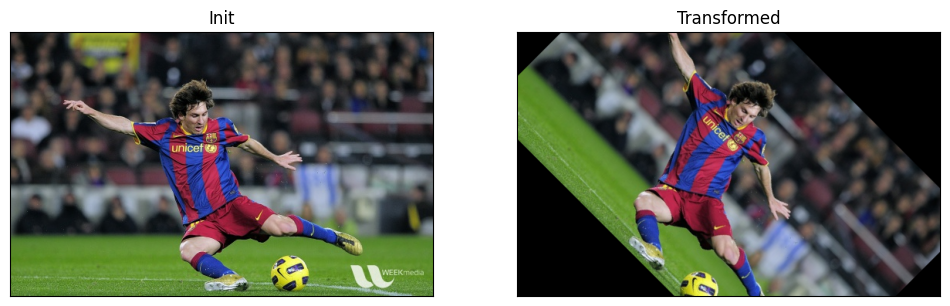

In [11]:
plot_image_before_after(image_messi, rotate_center_affine(image_messi, -45))

<br>

**Способ 2** - Поворот изображения относительно его центра с помощью scipy.

Задание функции, поворачивающей изображение относительно его центра:

In [12]:
def rotate_center_ndimage(img: np.ndarray, angle: float or int):
    img_center = [int(coord) for coord in np.array(img.shape[1::-1]) / 2]
    center_x, center_y = img_center
    
    pad_x = [img.shape[1] - center_x, center_x]
    pad_y = [img.shape[0] - center_y, center_y]
    
    img_padd = np.pad(img, [pad_y, pad_x, [0, 0]], 'constant')
    img_rotation = ndimage.rotate(img_padd, angle, reshape=False)
    
    result = img_rotation[pad_y[0] : -pad_y[1], pad_x[0] : -pad_x[1]]
    
    return result

Поворот изображения:

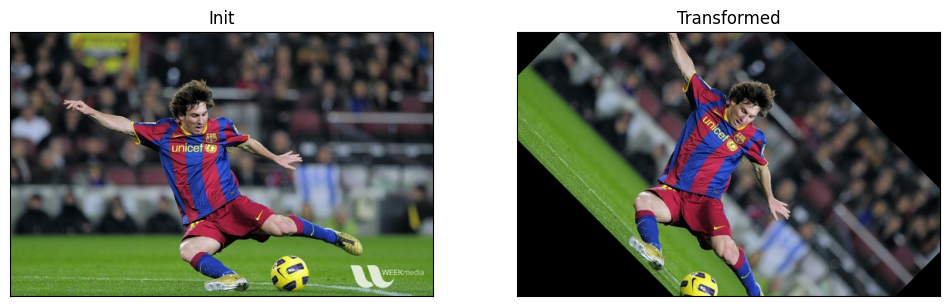

In [13]:
plot_image_before_after(image_messi, rotate_center_ndimage(image_messi, -45))

<br>

**Способ 2** - Поворот изображения относительно его центра с помощью матриц.

Задание функции, поворачивающей изображение относительно его центра:

In [14]:
def rotate_center_simple(img: np.ndarray, angle: float or int) -> np.ndarray:
    
    img_center = [int(coord) for coord in np.array(img.shape[1::-1]) / 2]
    center_x, center_y = img_center
    
    rads = radians(angle)
    result = np.uint8(np.zeros(img.shape))

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            x = (i - center_x) * cos(rads) + (j - center_y) * sin(rads)
            y = -(i - center_x) * sin(rads) + (j - center_y) * cos(rads)
            
            bias_x, bias_y = 45, 90
            x = round(x) + center_x + bias_x
            y = round(y) + center_y + bias_y

            if (x >= 0 and y >= 0 and x < img.shape[0] and  y < img.shape[1]):
                result[i, j, :] = img[x, y, :]

    return result

Поворот изображения:

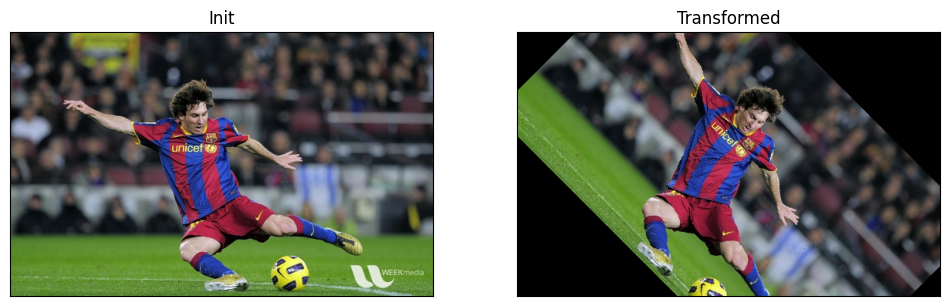

In [15]:
plot_image_before_after(image_messi, rotate_center_simple(image_messi, -45))

---

>**Задание 2**
>
>В папке находятся изображения (все кроме `messi5.jpg`), которые были подвернуты различным деформациям. Используя аффинные преобразования, необходимо "выправить" эти изображения (привести в исходный вид).

<br>

**Зеркальное отображение**

Чтение изображения:

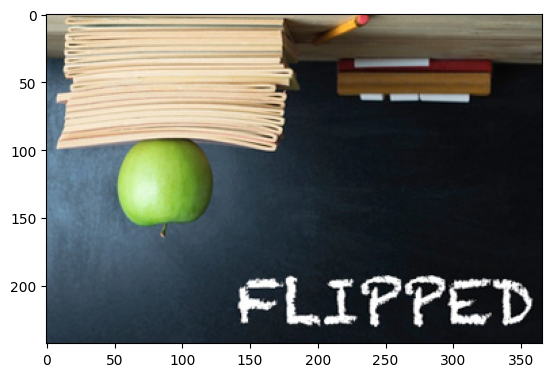

In [16]:
image_apple = get_image_rgb(PATH, 'apple.jpg')

plt.imshow(image_apple)

Отражение изображения:

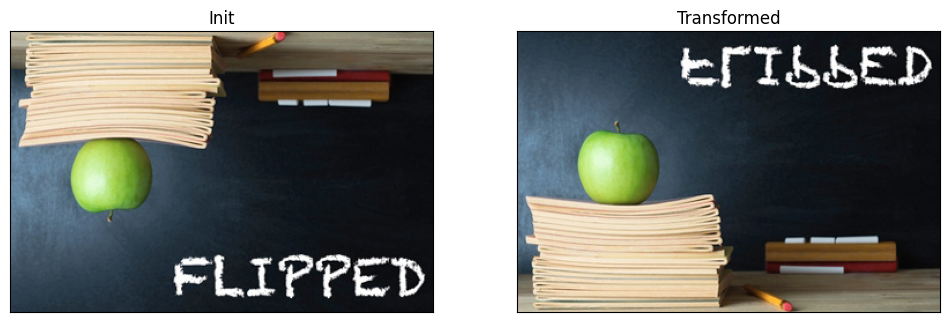

In [17]:
plot_image_before_after(image_apple, cv.flip(image_apple, 0))

Чтение изображения:

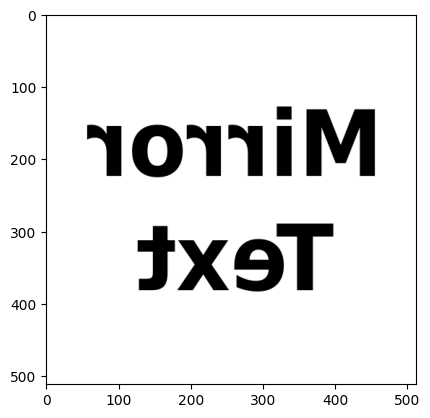

In [18]:
image_text = get_image_rgb(PATH, 'text.png')

plt.imshow(image_text)

Отражение изображения:

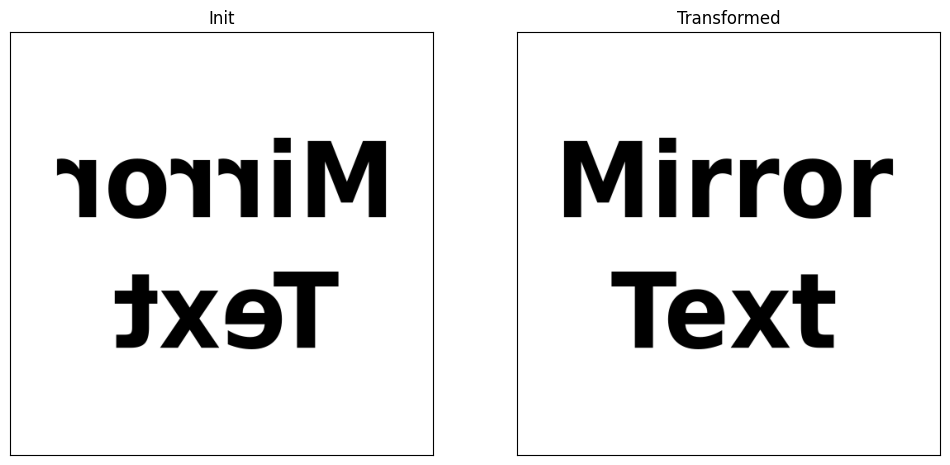

In [19]:
plot_image_before_after(image_text, cv.flip(image_text, 1))

<br>

**Коррекция перспективы** ([Perspective Transformation](https://theailearner.com/tag/cv2-warpperspective/))

Задание функции, отображающей переданные точки на изображении:

In [20]:
def plot_image_edges(img: np.ndarray, coords: List[Tuple[int]]) -> List[Tuple[int]]:
    plt.imshow(img)

    for i, coord in enumerate(coords):
        plt.scatter(*coord)
        plt.text(coord[0] - 80, coord[1] - 80, f'coord {i + 1}', color='red')
    
    plt.show()
    
    return coords

Задание функции коррекции перспективы изображения:

In [21]:
def correct_perspective(img: np.ndarray, points: List[Tuple[int]]) -> np.ndarray:
    a, b, c, d = points
    
    get_width_height = lambda x, y: np.sqrt(((x[0] - y[0]) ** 2) + ((x[1] - y[1]) ** 2))

    ad = get_width_height(a, d)
    bc = get_width_height(b, c)
    max_width = max(int(ad), int(bc))

    ab = get_width_height(a, b)
    cd = get_width_height(c, d)
    max_height = max(int(ab), int(cd))
    
    points_input = np.float32(points)
    points_output = np.float32([
        [0, 0],
        [0, max_height - 1],
        [max_width - 1, max_height - 1],
        [max_width - 1, 0]
    ])
    
    M = cv.getPerspectiveTransform(points_input, points_output)
    result = cv.warpPerspective(img, M, (max_width, max_height), flags=cv.INTER_LINEAR)
    
    return result

Чтение изображения:

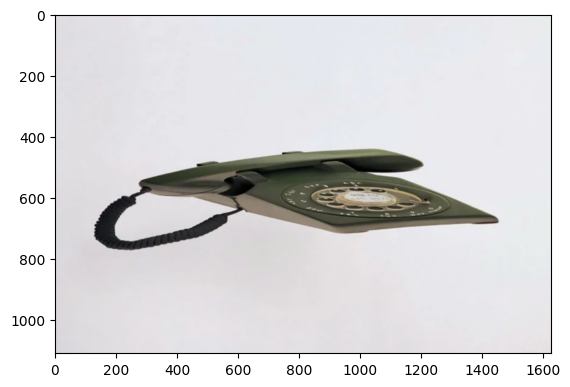

In [22]:
image_phone = get_image_rgb(PATH, 'phone.png')

plt.imshow(image_phone)

Выделение границ изображения:

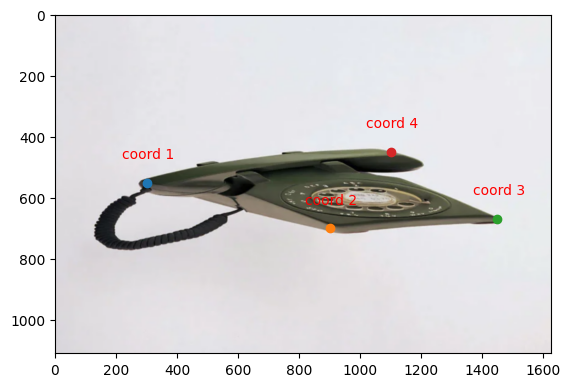

In [23]:
image_phone_coords = plot_image_edges(image_phone, [(300, 550), (900, 700), (1450, 670), (1100, 450)])

Коррекция перспективы изображения:

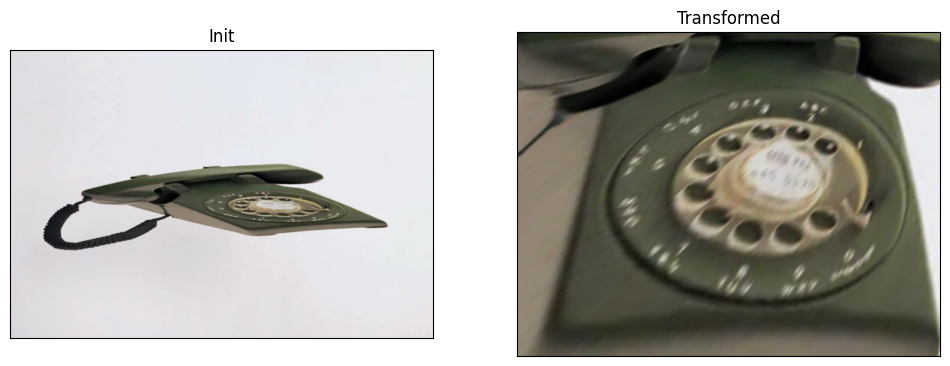

In [24]:
plot_image_before_after(
    image_phone,
    correct_perspective(image_phone, image_phone_coords),
    share_x=False,
    share_y=False
)

Чтение изображения:

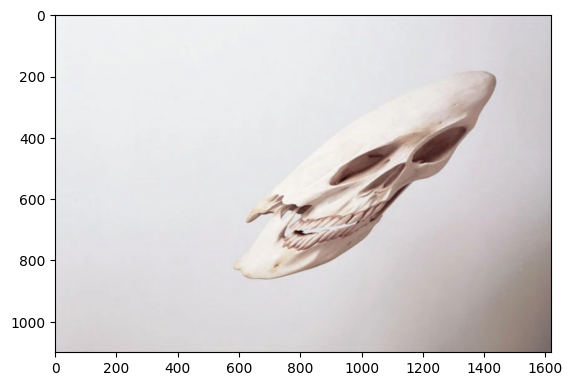

In [25]:
image_skull = get_image_rgb(PATH, 'skull.png')

plt.imshow(image_skull)

Выделение границ изображения:

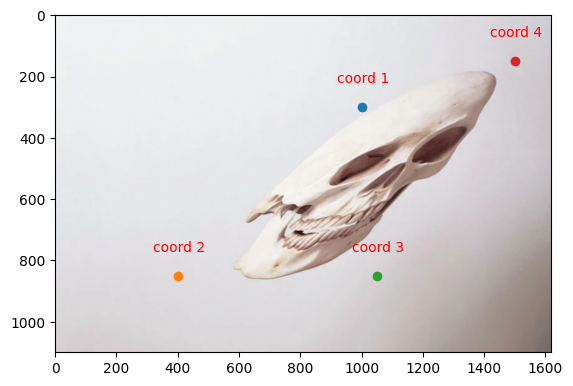

In [26]:
image_skull_coords = plot_image_edges(image_skull, [(1000, 300), (400, 850), (1050, 850), (1500, 150)])

Коррекция перспективы изображения:

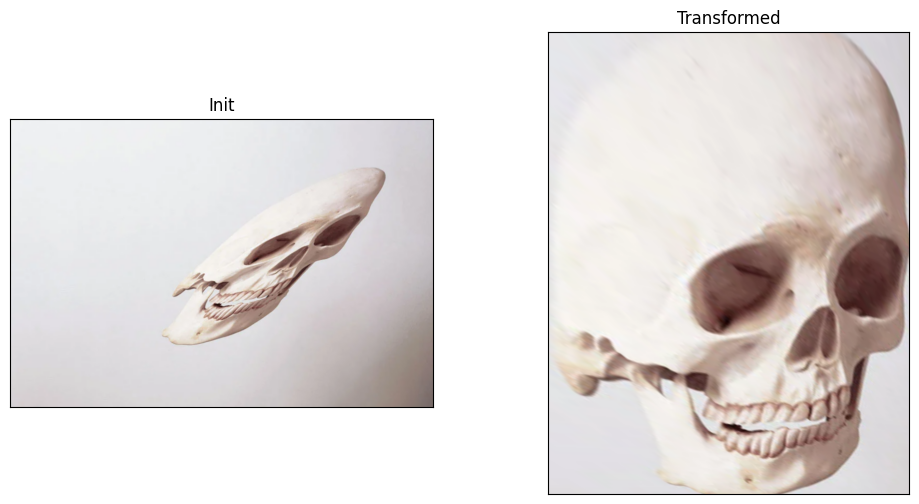

In [27]:
plot_image_before_after(
    image_skull,
    correct_perspective(image_skull, image_skull_coords),
    share_x=False,
    share_y=False
)

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Семинар-по-OpenCV-|-Домашнее-задание-3" data-toc-modified-id="Наверх" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        Наверх ↑
    </a>
</div>